<a href="https://colab.research.google.com/github/arjoca/RHDocentes/blob/main/RHDocentes_Futuro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RHDocentes - fevereiro 2022

**Notebook 2** - O Futuro e a Dinâmica de Aposentações

![](https://drive.google.com/uc?id=1TNBk1sOgEs7uC9H7D_qa3oHoK3w3hhyE)


Estudo organizado em 3 notebooks:
*   [O primeiro](https://github.com/arjoca/RHDocentes/blob/main/RHDocentes_Hoje.ipynb) - O ISEL hoje e as Desigualdades 
*   **Este notebook** - O Futuro e a Dinâmica de Aposentações
*   [O próximo](https://github.com/arjoca/RHDocentes/blob/main/RHDocentes_Corrige.ipynb) - Correção das Desigualdades

# Fontes de informação

*   Ficheiro "Afetacao_Financeira_ADs_Cursos_2021_v01.xlsx"
*   Ficheiro "RAIDES_0.xlsx"

Informação que depois de filtrada e anonimizada deu origem aos dados guardados no ficheiro [clean_data.xlsx](https://github.com/arjoca/RHDocentes/blob/main/clean_data.xlsx), usados neste estudo.

# Preparação

## Importação de módulos e leitura de dados

In [ ]:
# Instalação de módulos
!pip install kora -q
!pip install -U kaleido

In [ ]:
# Importação de módulos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from ipywidgets import widgets, interact, fixed
from IPython.display import Image

In [ ]:
# Leitura de dados
base_url = 'https://raw.githubusercontent.com/arjoca/RHDocentes/main/data/'
docentes = pd.read_csv(base_url + 'docentes.csv', encoding= 'unicode_escape', 
                       parse_dates=['Data Nascimento'], infer_datetime_format=True)
alunos_per_curso = pd.read_csv(base_url + 'alunos.csv', encoding= 'unicode_escape', index_col=0)
horas = pd.read_csv(base_url + 'horas.csv', encoding= 'unicode_escape', index_col=0)

## Inicializações

In [ ]:
# Designações dos cursos e departamentos
LISTA_DEPTS = sorted(docentes['Departamento'].unique())
LISTA_CURSOS = sorted(alunos_per_curso.index.unique())

In [ ]:
# Designações das categorias de docentes
cat_prof_coord = ['Prof. Coordenador', 'Prof. Coordenador c/ Agreg. ', 'Professor Coordenador Principal']
cat_convidado = ['Assistente Convidado', 'Professor Adjunto Convidado']
cat_adjunto = ['Professor Adjunto']
cat_assistente = ['Assistente do 2. Trienio', 'Assistente', 'Equiparado Assistente 2. Trienio']
cat_monitor = ['Monitor']
cat_quadro = cat_prof_coord + cat_adjunto
cat_todas = cat_quadro + cat_convidado + cat_assistente + cat_monitor

In [ ]:
# Dicionários com categorias de docentes e suas designações
catgs = {'Coordenadores':cat_prof_coord, 
         'Adjuntos': cat_adjunto,
         'Quadro': cat_quadro,
         'Convidados': cat_convidado,
         'Todas': cat_todas}
inv_catgs = {tuple(v): k for k, v in catgs.items()}

In [ ]:
# Horas de contacto usadas para determinar relações entre cursos e departamentos
horas_per_curso = horas.sum(axis=1)
pesos_dept_per_curso = horas.T / horas_per_curso

# Alunos por departamento
alunos_per_dept = pd.DataFrame(np.dot(pesos_dept_per_curso, alunos_per_curso),
                              index=pesos_dept_per_curso.index, columns=['Alunos'])
alunos_per_dept = alunos_per_dept['Alunos']
alunos_per_dept.name = ''
alunos_per_dept = alunos_per_dept.sort_index()

## Definição de funções

In [ ]:
# Filtragem de docentes atendendo à sua idade de aposentação 
def aposentados_e_ativos(df, ano, idade_reforma):
  idade = (datetime(ano, 1, 1) - df['Data Nascimento'])/timedelta(days=365.25)
  aposentados = df[idade > idade_reforma]
  ativos = df.drop(index=aposentados.index)
  return aposentados, ativos

In [ ]:
# Filtragem de docentes atendendo à sua categoria
def docentes_per_categoria(df, categoria):
  s = df.groupby(['Departamento', 'Categoria'])['ETI'].sum()
  s = s.loc[(slice(None), categoria)].droplevel(level=1)
  s = s.groupby(s.index).sum()
  s = pd.Series(s, index=LISTA_DEPTS)
  return s.fillna(0)

In [ ]:
# Desenho de gráfico com todos os valores iniciais ajustados a 100% no primeiro ano
def plot_ref_one(df, title='', size=(17,5), ymax=1.1):
  percentage = df/df.iloc[0]
  fig, ax = plt.subplots(1, 1, figsize=size)
  percentage.plot(ax=ax, linewidth=2)
  ax.set_title(title)
  ax.set_ylim(ymin=0, ymax=ymax)
  ax.set_xlim(xmin=0, xmax=len(df.index)-1)
  ax.grid(True)
  fig.savefig('temp_image.png')

# Olhar para o Futuro

## Evolução do Número de Alunos

**Hipótese:** Vamos assumir que se vai manter tudo constante 

**Questões:**

*   Será que faz sentido esta hipótese?
*   Quais as áreas onde se prevê haver maior acréscimo de procura?
*   Não será o DEETC já demasiado grande, no contexto do ISEL?

In [ ]:
# Janela temporal a usar
ANOS = 10
LST_ANOS = range(2022, 2022+ANOS+1)

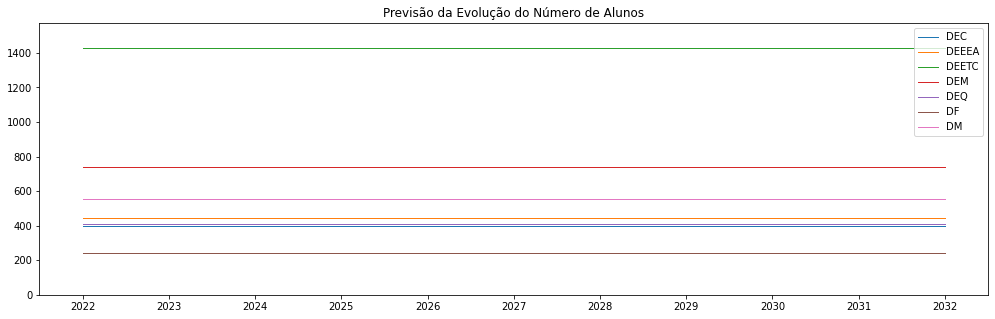

In [ ]:
# Evolução do número de alunos
df = pd.DataFrame([alunos_per_dept.values for ano in LST_ANOS], 
                  columns=alunos_per_dept.index, index=LST_ANOS)
fig, ax = plt.subplots(1, 1, figsize=(17,5))
df.plot(ax=ax, linewidth=1)
ax.set_xticks(LST_ANOS)
ax.set_ylim(ymin=0, ymax=alunos_per_dept.max()*1.1)
ax.set_title('Previsão da Evolução do Número de Alunos');

## A Dinâmica de Aposentações

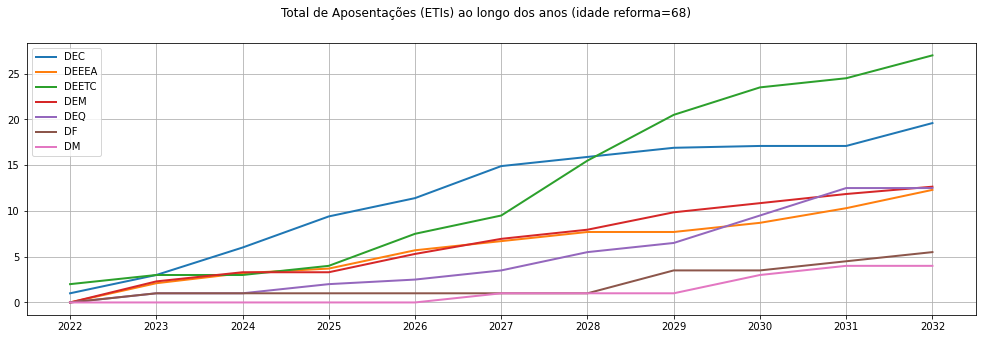

In [ ]:
# Total de aprosentações (ETIs) ao longo dos anos
idade_reforma = 68
df = pd.DataFrame(columns=LISTA_DEPTS)
for ano in LST_ANOS:
  ap, at = aposentados_e_ativos(docentes, ano, idade_reforma)
  df.loc[ano,:] = ap.groupby(['Departamento'])['ETI'].sum()
df.fillna(0, inplace=True)
fig, ax = plt.subplots(1, 1, figsize=(17,5))
df.plot(ax=ax, linewidth=2)
fig.suptitle(f'Total de Aposentações (ETIs) ao longo dos anos (idade reforma={idade_reforma})')
ax.set_xticks(LST_ANOS)
ax.grid(True)

In [ ]:
# Função que retorna/visualiza dataframe com a evolução temporal de recursos docentes para uma dada categoria
def time_evolution_eti(categoria, lst_anos, reforma=68, plot=False):
  df = pd.DataFrame([docentes_per_categoria(docentes, categoria)], 
                    index=[str(lst_anos[0])], columns=LISTA_DEPTS)
  for ano in lst_anos[1:]:
    ap, at = aposentados_e_ativos(docentes, ano, reforma)
    s = docentes_per_categoria(at, categoria)
    s.name = str(ano)
    df = df.append(s)
  if plot:
    plot_ref_one(df, f'Ritmo de aposentações na categoria de {inv_catgs[tuple(categoria)]}')
  else:
    return df

In [ ]:
# Ritmo de aposentações para cada categoria (interativo)
interact(time_evolution_eti, lst_anos=fixed(LST_ANOS), plot=fixed(True), 
         categoria=widgets.Dropdown(options=catgs, value=cat_todas), reforma=(67,70,1));

interactive(children=(Dropdown(description='categoria', index=4, options={'Coordenadores': ['Prof. Coordenador…

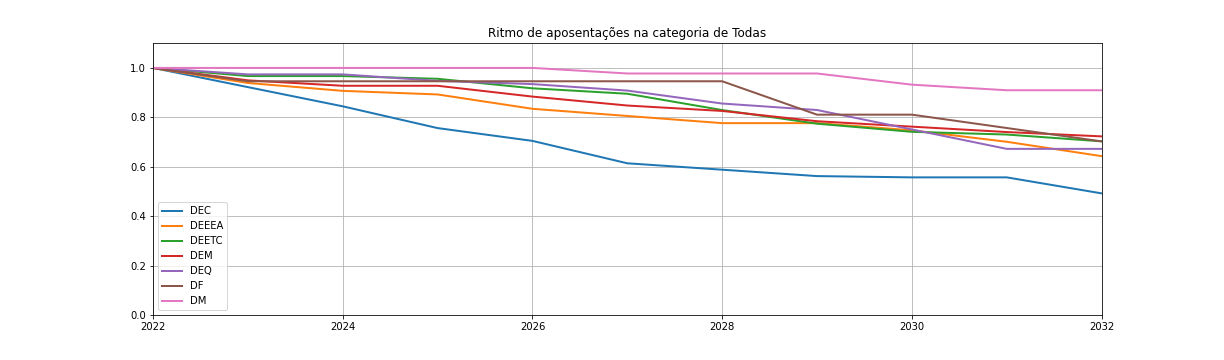

In [ ]:
# Figura estática
Image('temp_image.png')

## Caso da categoria de Professores-coordenadores

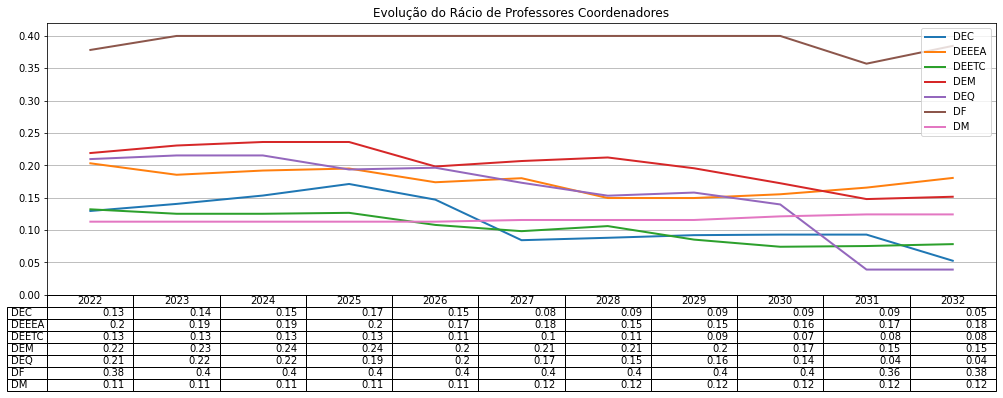

In [ ]:
# Qual a dinâmica do rácio de professores coordenadores
df_coord = time_evolution_eti(cat_prof_coord, LST_ANOS)
df_todos = time_evolution_eti(cat_todas, LST_ANOS)
df = df_coord/df_todos
fig, ax = plt.subplots(1, 1, figsize=(17,5))
df.plot(ax=ax, linewidth=2, table=np.round(df.T, 2))
ax.xaxis.set_visible(False)
ax.set_ylim(ymin=0, ymax=0.42)
ax.grid(True)
ax.set_title('Evolução do Rácio de Professores Coordenadores');

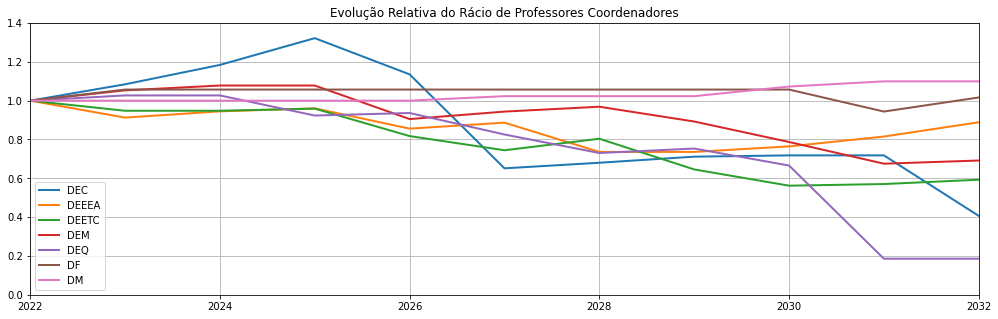

In [ ]:
# O mesmo gráfico mas agora com a evolução relativamente aos valores no presente (2022)
plot_ref_one(df, title='Evolução Relativa do Rácio de Professores Coordenadores', ymax=1.4)